### compare the number of qtls found with PC and PEERs residualization

look at https://www.biorxiv.org/content/10.1101/2022.03.09.483661v1.full.pdf for examples of how to do this type of comparision

* number of discovered cis-eGenes
* number of credible sets
* number of clusters

In [79]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import spearmanr, linregress
import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')


from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml

tissue_pal = sns.color_palette('blend:#B83A4B,#FEC51D,#67AFD2', n_colors=len(tissue_ids))


load in the overlap dfs for each pc and peer


In [10]:
pc_config_path= f'{prefix}/config/new_clusters/proteincoding_pcs.yaml'
with open(pc_config_path, 'r') as f:
    pc_config = yaml.safe_load(f)

peer_config_path= f'{prefix}/config/new_clusters/proteincoding_rewrite.yaml'
with open(peer_config_path, 'r') as f:
    peer_config = yaml.safe_load(f)

tissue_id_path = peer_config['tissue_id_path']
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])

tissue_id = 'Cells_Cultured_fibroblasts'


load in for one tissue at first

In [18]:
pc_counts = pc_overlap_df.groupby('orig_cs_dataset').count()['cs_full_id']
peer_counts = peer_overlap_df.groupby('orig_cs_dataset').count()['cs_full_id']

In [20]:
peer_counts

orig_cs_dataset
control_eqtl    1808
pc_qtl          1675
Name: cs_full_id, dtype: int64

In [92]:
def get_qtl_counts(tissue_id, config):
    overlap_df = pd.read_csv('{}/{}/{}.v8.overlap.txt'.format(prefix, config['overlap_output_dir'], tissue_id), sep='\t')
    return overlap_df.groupby('orig_cs_dataset').count()['cs_full_id']

def get_cluster_count(tissue_id, config):
    cluster_df = pd.read_csv('{}/{}/{}_clusters_all_chr.csv'.format(prefix, config['clusters_dir'], tissue_id))
    return len(cluster_df)

def get_egene_count(tissue_id, config):
    overlap_df = pd.read_csv('{}/{}/{}.v8.overlap.txt'.format(prefix, config['overlap_output_dir'], tissue_id), sep='\t')
    return len(set(np.concatenate(overlap_df['cluster_id'].str.split('_'))))

In [93]:
def get_counts(config):
    counts = tissue_df['Tissue'].apply(get_qtl_counts, args=(config,))
    counts = tissue_df.join(counts)
    counts['clusters'] = counts['Tissue'].apply(get_cluster_count, args=(config,))
    counts['egenes'] = counts['Tissue'].apply(get_egene_count, args=(config,))

    return counts


pc_counts = get_counts(pc_config)
peer_counts = get_counts(peer_config)

In [94]:
joined_counts = pd.concat([pc_counts, peer_counts], keys=['pc', 'peer'], names=['residual_type', 'idx'])
joined_counts.reset_index(level=0, inplace=True)

joined_counts = joined_counts.melt(id_vars=['Tissue', 'residual_type'], var_name='count_type', value_name='count')

Text(0.5, 0.98, 'PC vs PEER QTL counts')

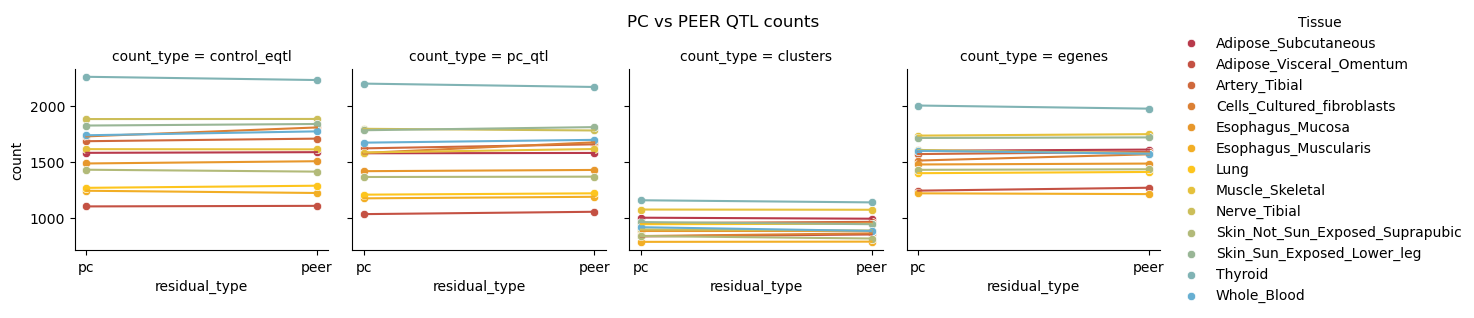

In [95]:
g = sns.FacetGrid(joined_counts, col="count_type", hue='Tissue', palette = tissue_pal)
g.map(sns.lineplot, "residual_type", "count")
g.map(sns.scatterplot, "residual_type", "count")
g.add_legend()
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('PC vs PEER QTL counts')

sharing of genes across conditions

I need a df of source-target-value

on the left and on the right eqtl, pcqtl, none, both? or should it 